# Notebook 3: Handwritten Character Recognition

## Using Machine Learning to Detect a 'W' in the demographic column

This notebook builds upon the image processing work in the document segmentation notebook. The code from that notebook has been consolidated into a file called 'segmentation.py' and will be imported for use in this notebook. This notebook will demonstrate a machine learning approach to recognizing handwritten characters, using a layered *neural network* that is trained on the publically available EMNIST letters dataset. The E in EMNIST stands for Extended, as it is an extended version of the MNIST dataset, which is the Modified National Institute of Standards and Technology (NIST) dataset of handwritten digits. Before you can train a machine learning model (or neural network) on the digit dataset you have to download it from the NIST website. Lucky for us, the Keras toolkit now includes functions that automate the download of the dataset the first time that you use it. Be forewarned that this code will take a long time to execute the first time, depending upon your network speed.

This notebook is partially based on the [Keras MNIST tutorial](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb) written by Daniel Moser (UT Southwestern Medical Center). We modify their approach to focus on letters exclusively and explore training a NN and Convolutional NN (CNN) to specialize in recognizing the W character alone.

## Install Dependencies
The first step is to install some necessary Python libraries for machine learning. We are using the Google suite of tools, which include *TensorFlow* and *Keras*, which is a somewhat simpler API that wraps the base functions provided by TensorFlow. Please Note: There is a strange situation with Keras version 3 that requires it to be installed (or reinstalled) after you install tensorflow. (TensorFlow tries to install it's own earlier version of Keras.)

Be sure to restart your Jupyter notebook kernel after these tools have been installed.

Note: You may have already installed these tools via the Pipenv tool.

In [3]:
%pip install --upgrade tensorflow=="2.16.1" numpy tensorflow-datasets=="4.9.4"
%pip install --upgrade keras=="3"

  Using cached numpy-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.5
    Uninstalling tensorflow-datasets-4.9.5:
      Successfully uninstalled tensorflow-datasets-4.9.5
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Loading the EMNIST image data into a TensorFlow Dataset

The next step is to setup the tensorflow training dataset that contains the digits that we want to use to train a model. EMNIST includes thousands of grayscale images that are 28x28 pixels in size with 256 levels of gray. The images are numerically labelled with the letter represented in the image. For instance, a 'W' is labelled with the number 23. The following code uses the TensorFlow Datasets module to load our chosen dataset. It will download the data the first time that you run it, which can take some time. Notice that we have specified some options to the `load()` function, saying that we desire only letters. It also specifies that we want the dataset split into  both training data and testing data. The testing data will be used to measure the accuracy of our model after training. We also load information about the dataset into a separate Python dictionary.

First we print out the dataset info object, then we display a grid of the first 9 images in the dataset, so that you can see what the images look like.

2025-01-16 11:44:24.539106: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 11:44:24.539352: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 11:44:24.541428: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 11:44:24.567261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 11:44:25.059774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/home/jansen/tensorflow_datasets/emnist/letters/3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    }),
    supervis

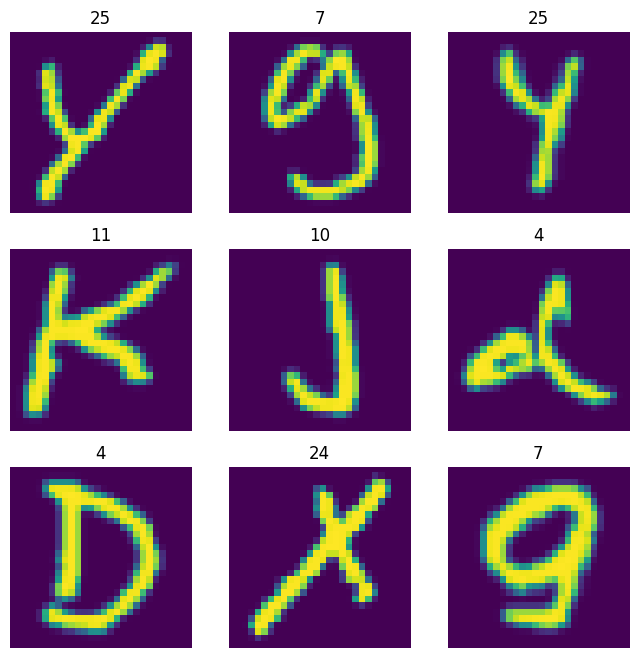

In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import tensorflow as tf

#from tensorflow.keras.utils import to_categorical              # NumPy related tools

# Data should be located in a folder called EMNIST
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(ds_info)

plt.figure(figsize=(8, 8))
for i, (img, lbl) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.transpose(img, perm=[1,0,2]))
    plt.title(str(int(lbl)))
    plt.axis("off")

You may notice that the letters look pretty strange. They are in fact inverted horizontally and rotated 90 degrees anti-clockwise. This is a legacy of the original EMNIST dataset and is maintained in the tensorflow version for consistency. You can read this explanation in the dataset information we printed above. There are also instructions there for how to make the images match our expectations and we will follow those in steps below.

**Please Note:**  The number of classes (labels) for the images is listed as 37 in the dataset information dictionary. This is in fact a typo in the TensorFlow dataset's description, as of the 3.0 version the typo is still there. The same typo occurs in the original EMNIST paper, where the number of classes in the "letters" subset is reported as both 37 AND 26 in different places. I discovered this discrepancy towards the end of my analysis. We can simply treat the number of classes as 26 and ignore the incorrect 37.

## Census Data

Let's load and preview some census demographic code images for comparison. Remember that we are training a model to recognize the census W's based entirely on these EMNIST examples. The two data sources do not resemble each other much yet, but we can take steps to bring them closer together.

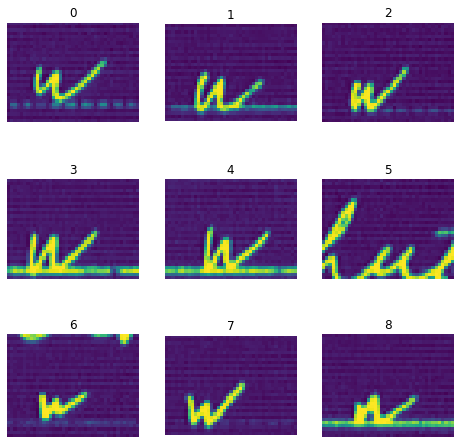

In [2]:
# First we load the segmentation code that we developed in that notebook
with open("segmentation.py") as f:
    code = f.read()
exec(code)

page = "pages/43290879-California-101393-0002.jpeg"
cells = list(generateCellImages(page))
plt.figure(figsize=(8, 8))
for i, image in enumerate(cells[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(str(i))
    plt.axis("off")


If you compare the Census 'W' images to the EMNIST letters, you should notice a few things:

* The EMNIST images are 28 by 28 pixels square, whereas the Census cell images are taller and wider.
* The EMNIST images are rotated and flipped, whereas the Census cell images are oriented normally.
* The Census images contain some extraneous ink, usually a horizontal rule that marks the botton of the demographic cell. This noisy line is sometimes faint and sometimes heavy. The EMNIST image consist of clear and crisp letters with no extraneous ink.
* EMNIST letters are centered within the 28 pixel square using a bounding box technique. This leaves an even margin on the top and bottom and on the left and right. Our 'W' images are not well centered.

## Dealing with the horizontal rule
In an earlier version of this project we addressed the noisy horizontal line by adding a similar line to our training data. We would generate some random noise and add it to a few rows near the bottom of the EMNIST characters. This worked fairly well (recognizing 2/3 of W characters). Ultimately, however, more noise will be more input that must be ignored by the recognizer function. The noise also makes it difficult to center the census code within a 28x28 box, since the edges are not crisp. After avoiding such involved techniques at first, we finally decided to try and remove the noise from the census images through computer vision techniques. 

The function below detects horizontal rows near the bottom of the image which have cumulative pixel values that are greater than a threshold value. These lines are erased. As erasing horizontal lines may leave some gaps in the demographic code strokes, we perform a healing operation (dilation followed by erosion), using a vertical structuring element. This replaces the erased parts of any near vertical lines.

In [3]:
import numpy as np

def close( img ):
    kerns = [
        #cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
        np.array([[ 1, 1, 1 ], [ 0, 1, 0 ], [0, 1, 0 ]], dtype=np.uint8),
        #np.array([[ 0, 1, 0 ], [ 0, 1, 0 ], [0, 1, 0 ]], dtype=np.uint8),
        #np.array([[ 1, 0, 0 ], [ 0, 1, 0 ], [0, 0, 1 ]], dtype=np.uint8),
    ]
    for k in kerns:
        img = cv2.dilate(img, k, iterations=2)
        img = cv2.erode(img, k, iterations=2)
    return img

def zap_lower_horiz_lines(img, debug=False):
    if debug:
        view(img, "with horiz line")
    h_ink = np.sum(img, axis=1)
    idx = np.argmax(h_ink)
    if(idx > 20 and h_ink[idx] > 3000):
        img[idx, :] = 0
        view(img, "deleted")
        #img[idx-1:idx+1, :] = close(img[idx-1:idx+1, :])
        view(img, "repaired")
        h_ink = np.sum(img, axis=1)
        idx = np.argmax(h_ink)
        if(False and idx > 20 and h_ink[idx] > 2000):
            img[idx, :] = 0
            view(img, "deleted 2")
        img[idx-2:idx+2, :] = close(img[idx-2:idx+2, :])
        view(img, "repaired 2")
    return img

The zap_lower_lines() function will be called by another function called crop_cell(), which will make all of the adjustments to our census images prior to recognition.

After removing the horizontal line, we use the findContours() function to find all of the shapes and then we select the shape with the largest area. This is assumed to be a W, whenever the image is a W. We then make a stencil from this shape and erase all of the ink outside of this shape, giving it a crisp outline.

Once we have this crisp image of the glyph, we perform an affine transform to rescale and shift the glyph into the center of a 28x28 pixel image.

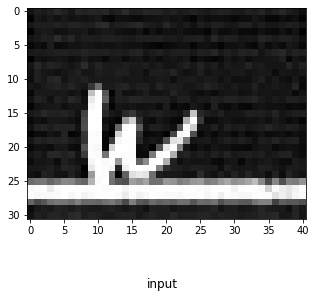

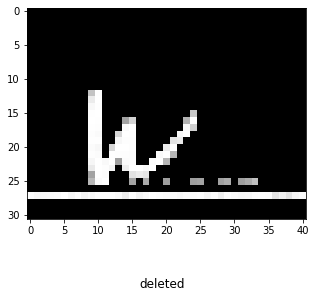

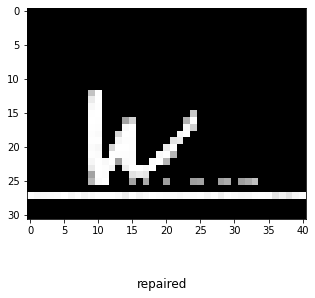

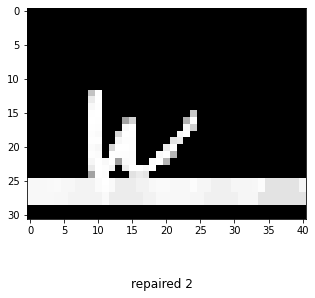

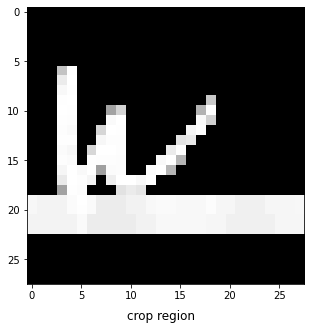

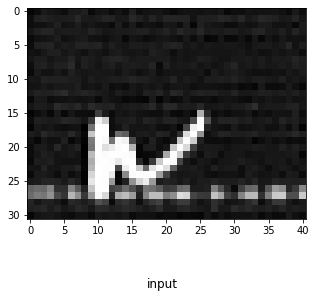

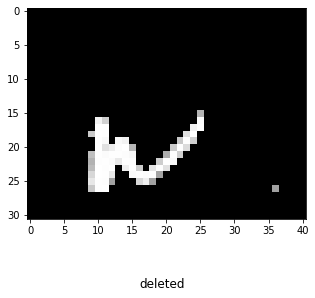

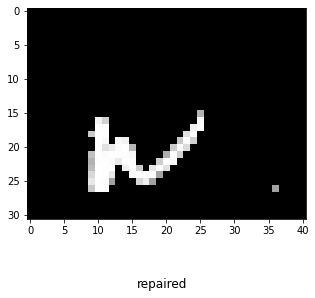

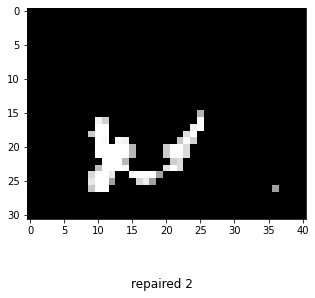

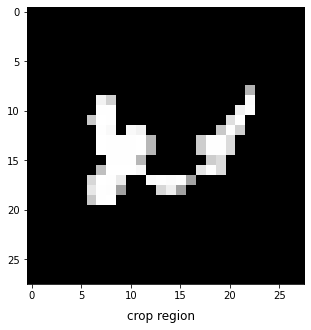

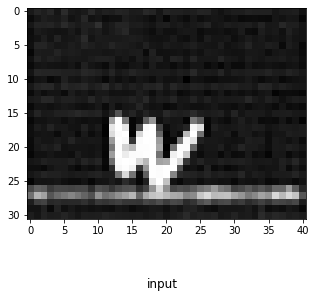

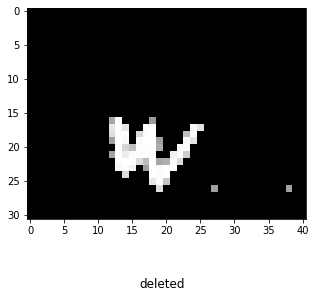

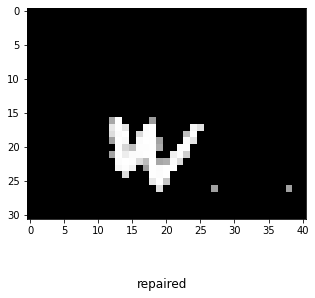

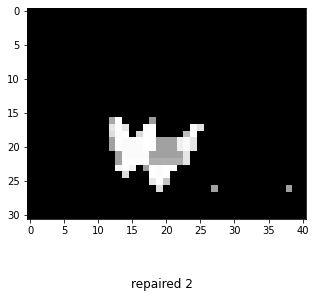

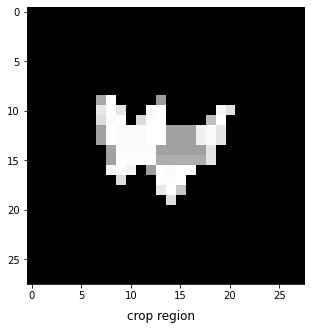

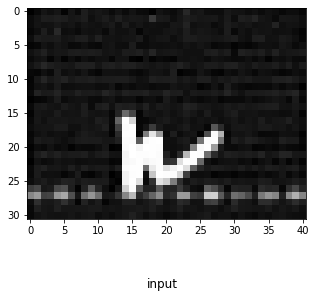

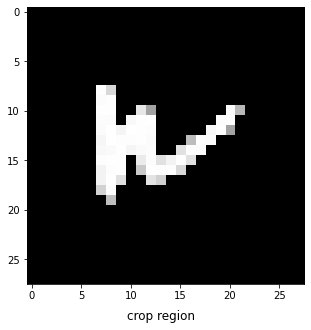

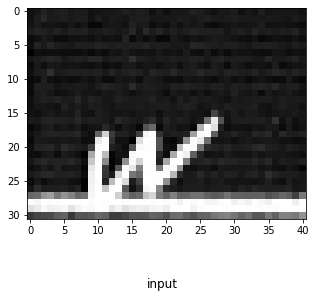

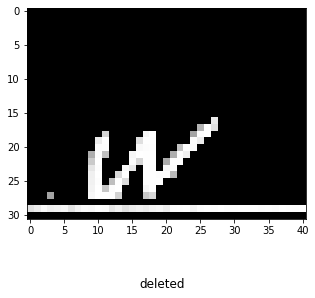

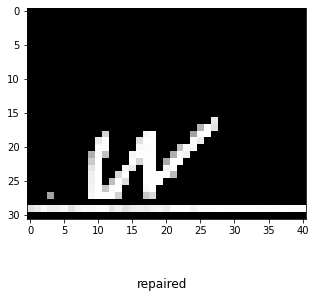

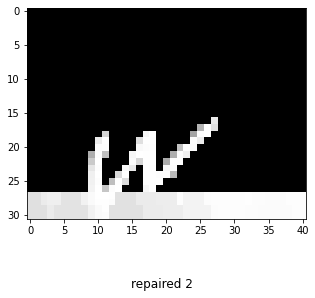

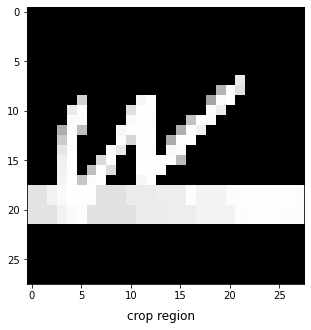

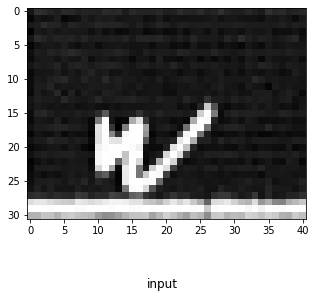

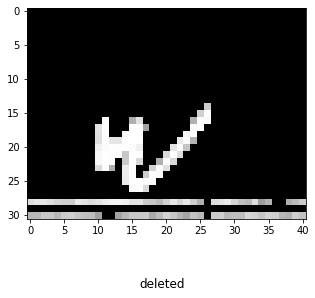

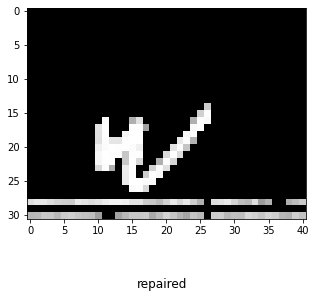

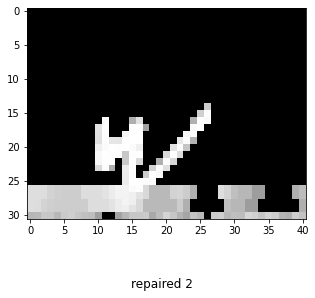

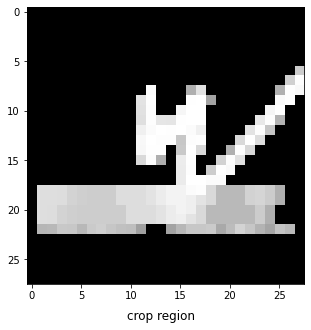

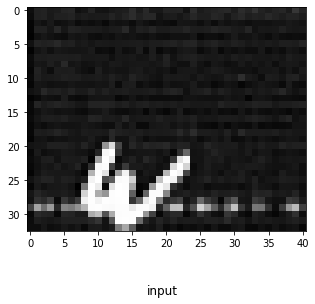

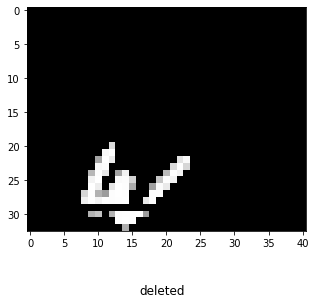

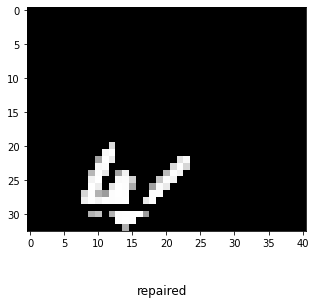

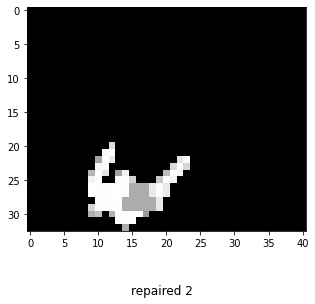

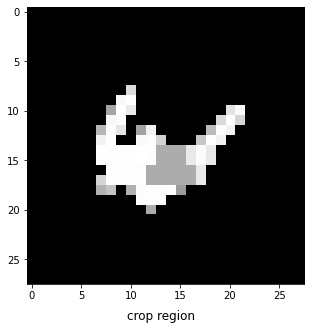

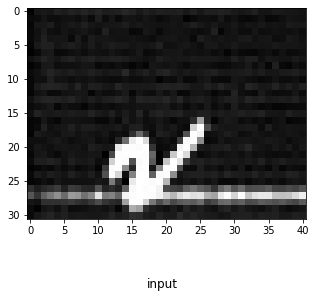

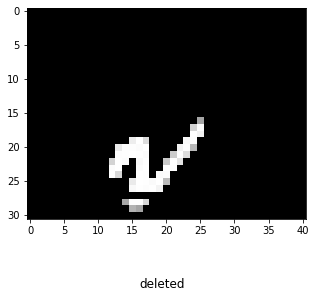

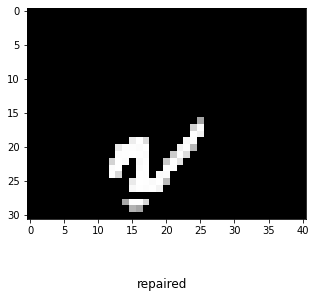

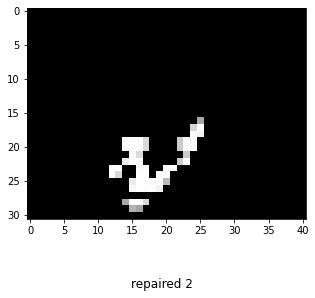

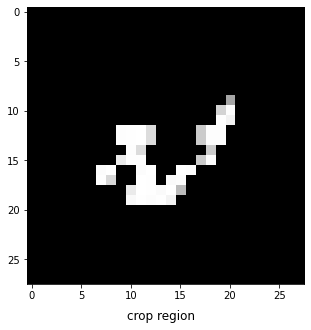

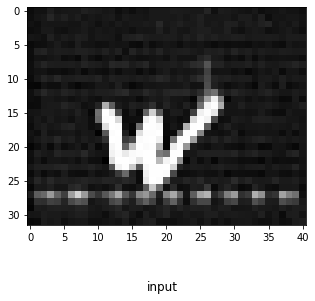

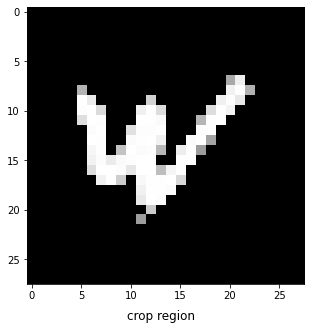

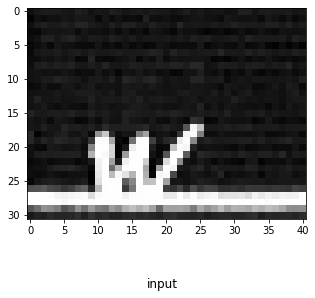

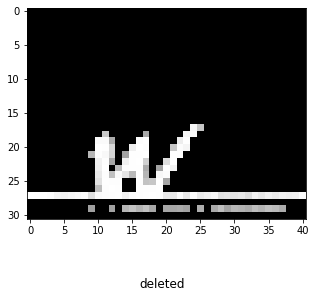

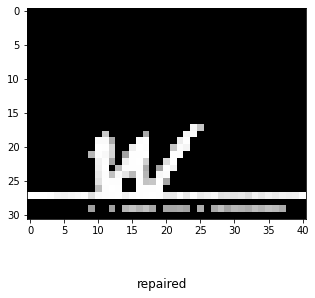

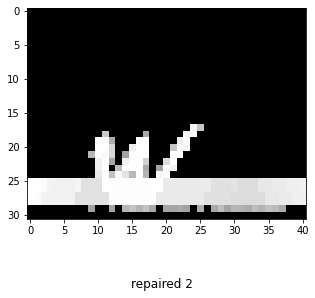

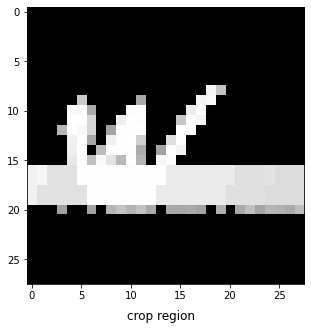

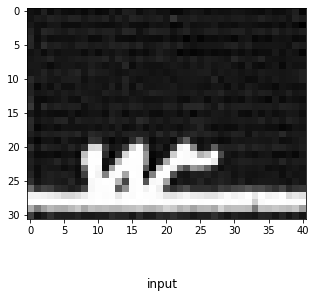

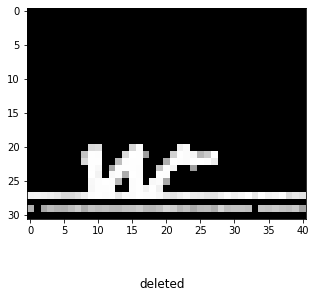

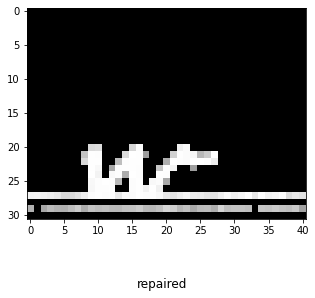

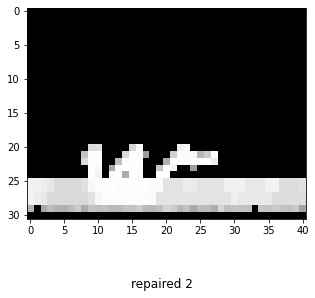

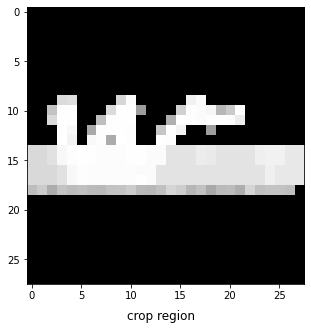

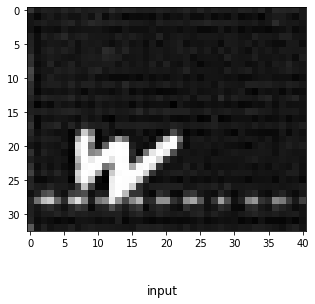

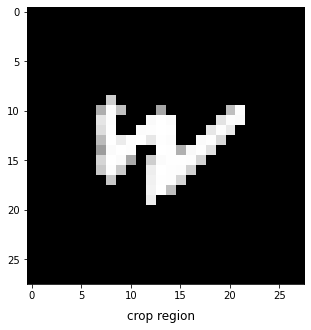

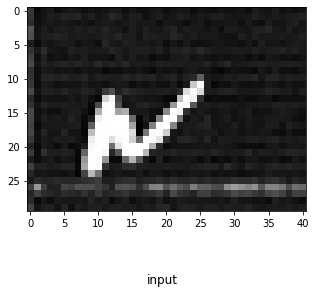

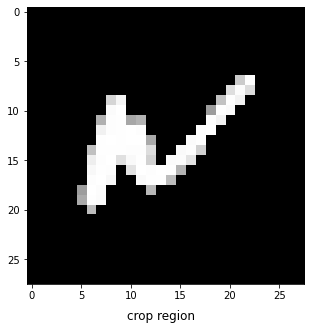

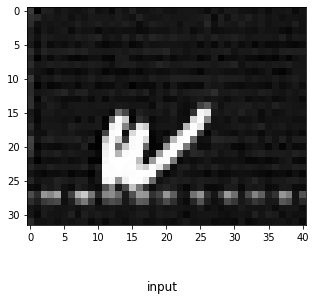

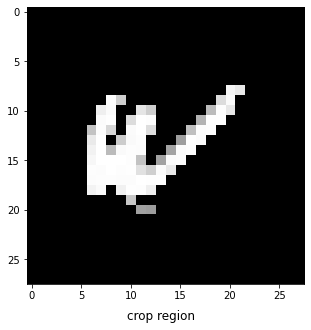

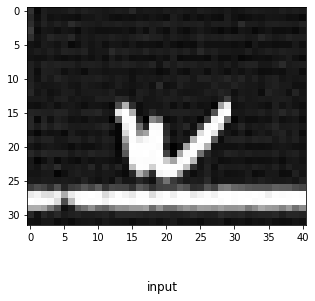

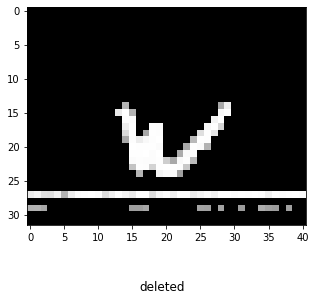

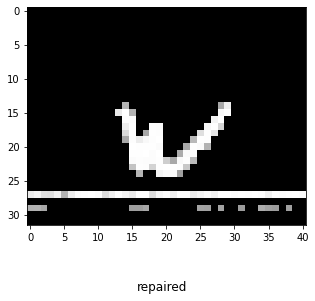

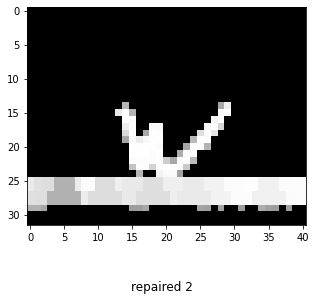

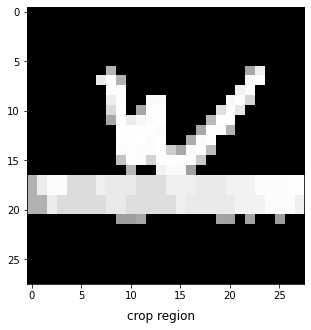

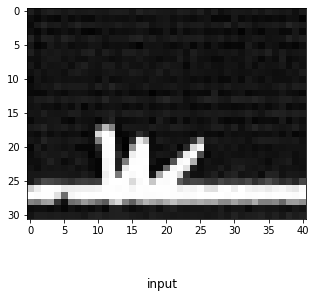

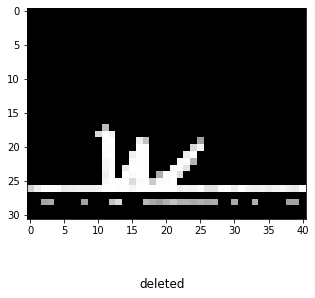

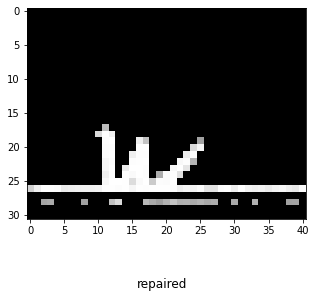

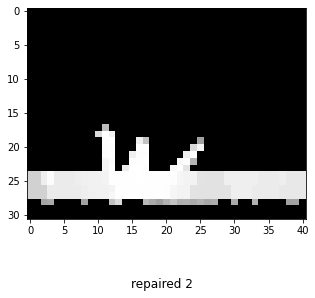

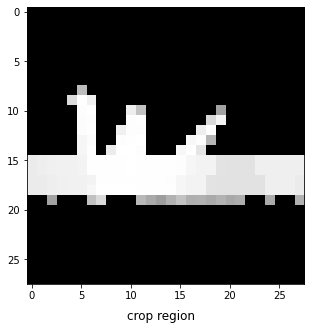

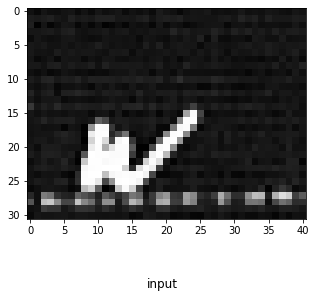

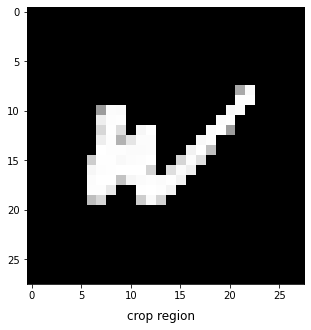

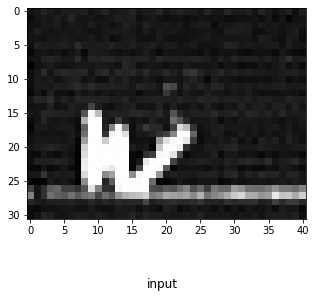

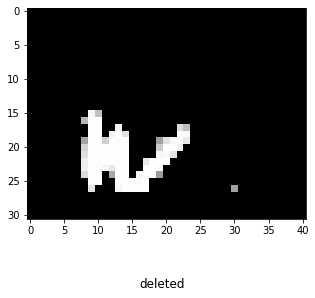

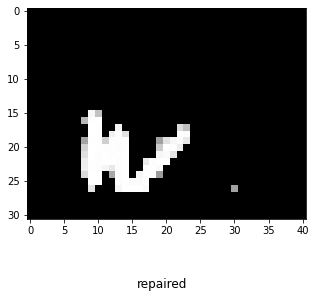

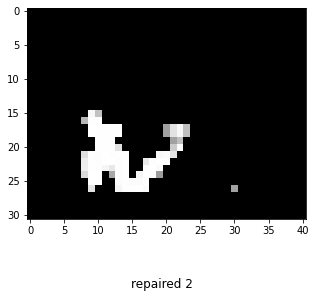

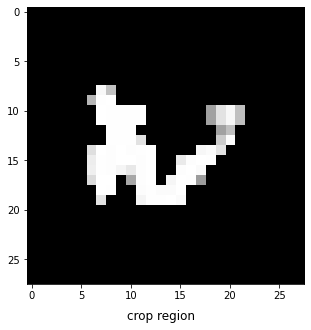

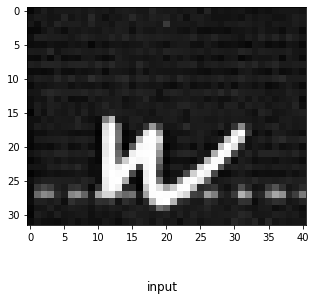

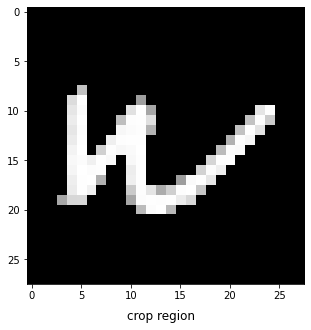

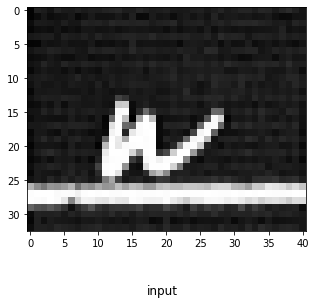

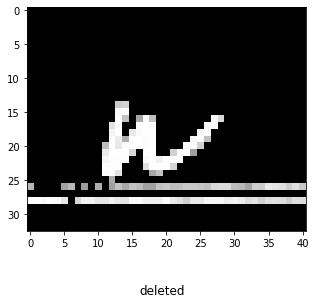

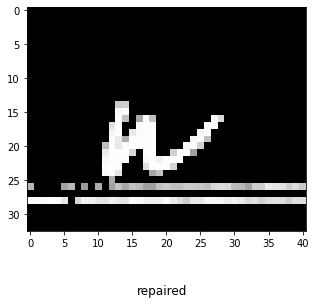

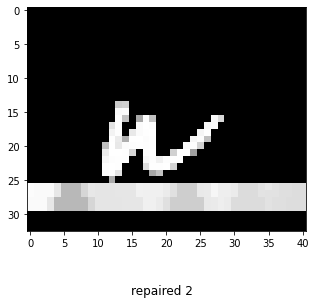

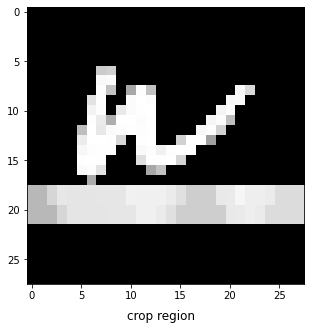

In [4]:
def crop_cell(cell_img, debug=False):
    if debug:
        view(cell_img, "input")
    ret,cell_img = cv2.threshold(cell_img,155,255,cv2.THRESH_TOZERO)
    cell_img = zap_lower_horiz_lines(cell_img)

    contours, hierarchy = cv2.findContours(cell_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # Find the largest contour by area
    areas = [cv2.contourArea(c) for c in contours]
    contour = contours[np.argmax(areas)]
    stencil = np.zeros(cell_img.shape).astype(cell_img.dtype)
    stencil = cv2.drawContours(stencil, [contour], 0, 1, -1)
    cell_img = cv2.bitwise_and(cell_img, cell_img, mask=stencil)
    if False:
        view(cell_img, "first")

    # cut then resize rect area to 24x24 (2px border)
    rect = cv2.boundingRect(contour)
    center = ((rect[0]+int(rect[2]*0.5), (rect[1]+int(rect[3]*0.5))));
    translate_x = 14 - center[0]
    translate_y = 14 - center[1]
    translation_matrix = np.float32([ [1,0,translate_x], [0,1,translate_y] ])
    img_translation = cv2.warpAffine(cell_img, translation_matrix, (28, 28))
    if debug:
        view(img_translation, "crop region")
    return img_translation

page = "pages/43290879-California-101393-0014.jpeg"
cells = list(generateCellImages(page))
for image in cells[:20]:
    crop_cell(image, debug=True)



## Transpose ENMIST Letters to a Readable Orientation

Now that we have a 28x28 square census image, let's make sure that we unrotate and unflip the EMNIST images so that they look like the normal readable letters from the Census. In order to do that we are going to use a TensorFlow *map()* operation to apply the same function, in a streaming fashion as needed, to every image in the training and testing sets. The function we will apply to every image is the TensorFlow *transpose()* function, which is the one recommended in the dataset notes. You can see that our preview grid is now readable.

2025-01-16 11:45:06.968711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-01-16 11:45:06.973259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


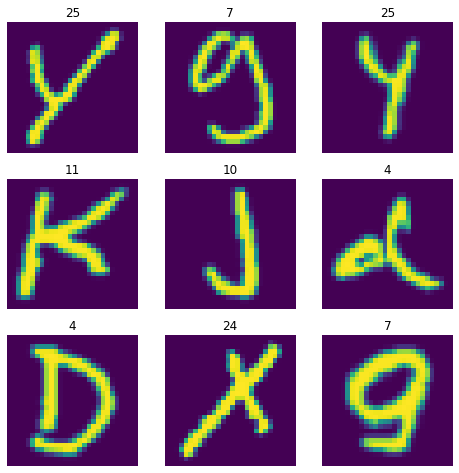

In [5]:
import tensorflow as tf

import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train_readable = ds_train.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

plt.figure(figsize=(8, 8))
for i, (img, lbl) in enumerate(ds_train_readable.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(str(int(lbl)))
    plt.axis("off")

## Applying Functions (Mapping) and Normalizing to Floating Point Values

We have shown some examples of the transformations that we need, both to the Census images and to the EMNIST letters training and testing data. Now we will apply those tranformation to the EMNIST training and testing data. Each transformation is applied in a series of steps using the *map()* function.

This code is a bit hard to read. When training our model the TensorFlow API will pull data from the training dataset. As each training image is prepared for use, it will apply our mapped functions. This code tells the TensorFlow API which functions are mapped onto the dataset and in what order they are to be applied. The testing dataset is prepared similarly.

### Further Details

For those interested in more detail. The TensorFlow API likes to precache and batch training data for performance reasons. The API user has to define the size of these batches. Batches have the effect of reshaping the data, adding a dimension to the tensor arrays for holding the batch index. So instead of a 28x28 image and a label, after batching you have a 128x28x28 array of data. This can be pretty confusing to those new to TensorFlow and makes it harder to interpret training error messages about the shape and dimensionality of the training data.

In [6]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("initial element spec", ds_train.element_spec)

ds_train_readable = ds_train.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

# Mapping the noisy line function to the dataset..
#ds_train_readable_noisy = ds_train_readable.map(
#  lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
#  num_parallel_calls=tf.data.AUTOTUNE, 
#  deterministic=False)

# Function to convert image pixel values to floating point between 0 and 1.
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# Mapping the normalize function to the dataset
ds_train_readable_float = ds_train_readable.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

def set_shapes(image, label):
  image.set_shape([28, 28, 1])
  label.set_shape([])
  return image, label

# Assert the correct tensor shapes
ds_train_final = ds_train_readable_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

# Some additional dataset setup steps
ds_train_final = ds_train_final.cache()
ds_train_final = ds_train_final.batch(128)  # This changes the shape of the data, so call it after all mapped functions..
ds_train_final = ds_train_final.prefetch(tf.data.AUTOTUNE)
print("final element_spec", ds_train_final.element_spec)

# Then we need to apply the same functions and settings to the test dataset
ds_test_readable = ds_test.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

# ds_test_readable_noisy = ds_test_readable.map(
#   lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
#   num_parallel_calls=tf.data.AUTOTUNE, 
#   deterministic=False)

ds_test_readable_float = ds_test_readable.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_readable_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_final.batch(128)
ds_test_final = ds_test_final.cache()
ds_test_final = ds_test_final.prefetch(tf.data.AUTOTUNE)
print("final test element_spec", ds_test_final.element_spec)

initial element spec (TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
final element_spec (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
final test element_spec (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


Above you can see that the final element spec is 4-dimensional, including the dimension used for the batch index. The final datatype has changed to floating point, i.e. values between zero and one. Even the labels in the 2nd part of the element spec tuple have changed shap to reflect the batching dimension.

## Defining and Training a Machine Learning Model

We are going to define the most straightforward machine learning model first and customize it for our parameters and the output we want. This model is defined as a sequence that takes in a 28 by 28 tensor array. The input is first flattened into a 784 long tensor array of one dimension (28 times 28). Then each of these *input features* is connected to each of the units in the subsequent neural network layer. The dense NN layer stores weights associated with each of these connections and those weights are used to determine the value each unit will pass to the next layer in the model. These weights are adjusted during training. An activation formular (relu) is supplied to this layer. The default activation formation is "linear", which means that unit output pretty directly reflect input and weights. Our activation formula of [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU) means that unit output never exceeds a certain maximum value and that any unit output below a certain threshold is attenuated, or lessened. This privileges the output of units that are strongly weighted and also receiving input.

Each unit in the first dense layer is subsequently connected to all of the 27 units in the last dense layer. The activation there is *softmax*, not ReLU. [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) is an activation that converts the output vector or 27 possibilities into a probability distribution, where all of the output values sum to 1. That makes it easier to compare the confidence of a model's predictions.

After you defined the neural network structure and activations in the first step, you compile that model, adding an optimizer, a loss function, and a metrics function. The loss function compare each prediction to the expected result in the training data. The model will be trained in steps to minimize this loss. Our loss function is categorical, which means that the model is judged on how well it chooses a category (a letter) based on the input it receives. The summary function prints a nice display of the model we have constructed.

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(28,28), name='input'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(27, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 27)                │      3,483 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 103,963 (406.11 KB)

 Trainable params: 103,963 (406.11 KB)

 Non-trainable params: 0 (0.00 B)

In the summary above you can see how many trainable parameters there are within the model we have defined. Each trainable parameter is the weight of a connection between one layer and the next. So 784 inputs are each connected to all 128 units (or neurons) in the dense layer, for 784 x 128 weights or 100,480 parameters. Then in the next layer you have 128 outputs connected to 27 units, for 128 x 27 weights, or 3,483 parameters. The total therefore is 103,963 trainable connections between inputs and neuron units.

Next, the *fit()* function performs the training, fitting the model to the training data. This can take a few minutes, depending upon the speed of your computer and available memory. The training is performed in 15 *epochs* and each epoch is a complete pass through the training data. As training is performed you will see metrics that show how accurate the model is at predicting labels in the test dataset.

In [8]:

model.fit(
    ds_train_final,
    epochs=15,
    validation_data=ds_test_final,
)

Epoch 1/15


/home/jansen/.local/share/virtualenvs/census-form-image-processing-VTyG8Y6d/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:568: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4317 - sparse_categorical_accuracy: 0.6024 - val_loss: 0.7360 - val_sparse_categorical_accuracy: 0.7837
Epoch 2/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6583 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.5814 - val_sparse_categorical_accuracy: 0.8273
Epoch 3/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5140 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.8444
Epoch 4/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4418 - sparse_categorical_accuracy: 0.8671 - val_loss: 0.4832 - val_sparse_categorical_accuracy: 0.8524
Epoch 5/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.4634 - val_sparse_categorical_accuracy: 0.8589
Epoch 6/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.8865 - val_loss: 0.4504 - val_sparse_categorical_accuracy: 0.8615
Epoch 7/15
694/

Superb! Look at that machine learn! In my training I am seeing a accuracy of 92.5 percent. You can see that in each epoch the loss is decreasing and the accuracy is improving as the weights (or trainable parameters) are adjusted.

You might wonder why the progress bars above are counting up to 694.. Can you guess? If each epoch is one pass through all the training data and each epoch is divided into 694 steps, then what is each step?

The answer is that each epoch is divided into the batches of 128 we defined in the training data.

The number of training examples in EMNIST letters is 88,800. This divides up into 694 batches of 128 examples, with the last batch being somewhat smaller (the remainder).

## Predicting a 'W' in the Census Images

Our next step is to attempt to use the model to predict if a Census image is a 'W' or not. Along the way we are going to gather some numbers so that we can measure the accuracy of this combination of image treatments and the prediction model. We measure accuracy as precision and recall, defined as follows:

precision = ratio of true Ws detected to number of Ws detected (true or not)
recall = ratio of true Ws detected to number of true Ws in total

In order to measure these stats, we have restricted our test run to a certain five pages, so 150 cell images. For those pages we have made lists of of the eight cells that are *not* Ws.

Let's try that with the model we've just trained.

The code below is an improvement on some of the *run()* functions we have used before in the image segmentation notebook. This run function takes a folder path, a page range, and a model. Since the census images we downloaded are named with a series of page numbers encoded after a final hyphen, such as "43290879-California-101393-0014.jpeg", we can use a regular expression to detect if a page is within the range of integers desired. If it is not, then we simply skip it. The *glob()* function will return files within the desired folder path and the *sort()* function will ensure that those files are returned in the right page order.

After we have a page image file we read in the image with OpenCV *imread()*. The image is passed to the *extract()* function from the `segmentation.py` file, which returns the properly positioned template for the main part of the census form as well as a deskewed and adjusted image we can use to extract cell images. We then use the template to calculate a list of rectangles or boxes that represent demographic cells from the census page (`demographic_cells`).

For each demographic cell, we crop a little image out of the page image (`cell_img`). We crop the cell image down to a 28x28 pixel square, removing the horizontal line. The 28x28 square is then normalized, just like our training data, into a tensor of floating point values. This tensor is expanded with an empty third dimension, just so that it matches our training data, which was three dimensions after it was batched. Having done this last step, we can finally call the *predict()* function and see what the model says about the cell.

The result is a tensor array of 27 floating point values that represent the probability distribution among the 27 possible categories, i.e. letters. You can print out the full result tensor if that is interesting to you. Our code selects the index with the maximum probability (highest value). For each page we plot all of the demographic cells in a 6 by 5 grid, with a view of each 28x28 cropped cell image and caption that includes the class (integer label), the letter (looked up in a list), and the probability value of the prediction.

Have a good look at the resulting plots of images and their predicted categories. What sort of image features impact predictions and their confidence? Are all of the 'W's predicted accurately? What other letters are often predicted instead of 'W' and why?

pages/43290879-California-101393-0002.jpeg


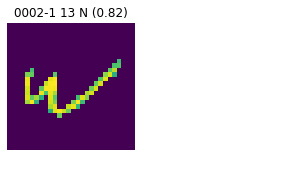

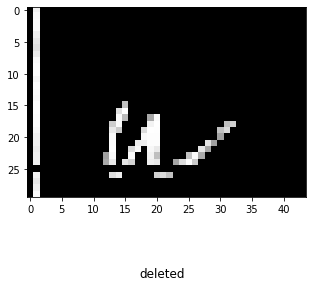

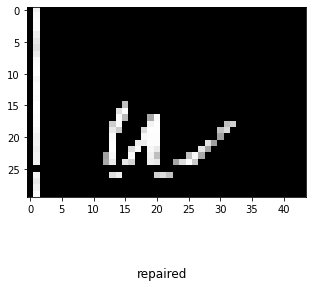

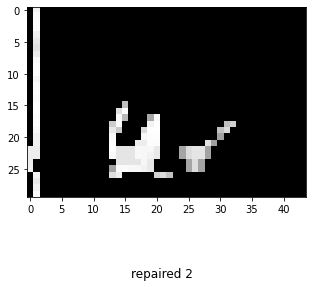

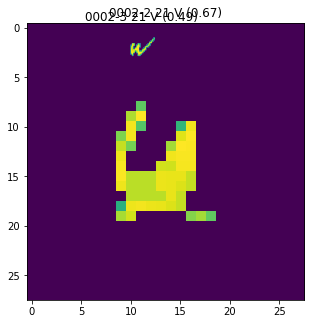

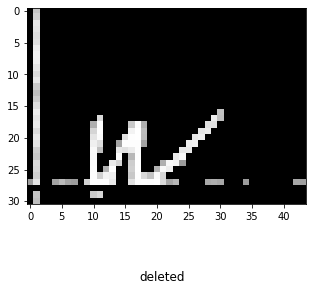

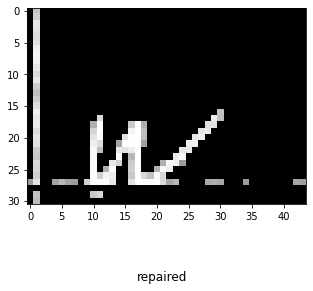

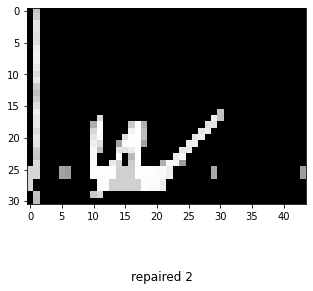

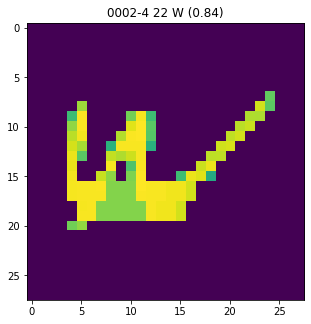

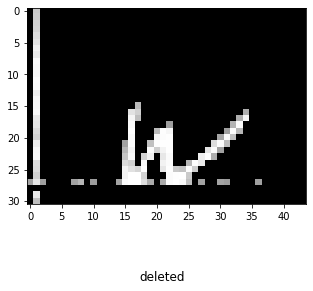

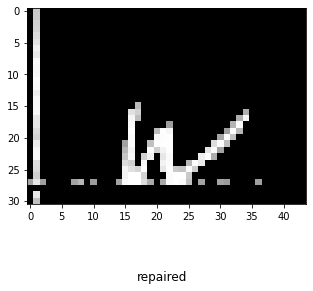

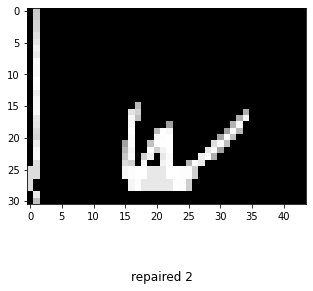

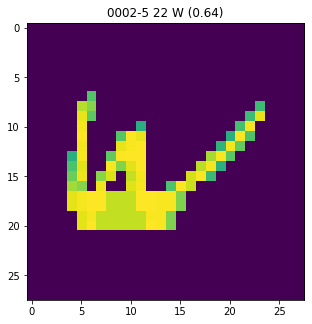

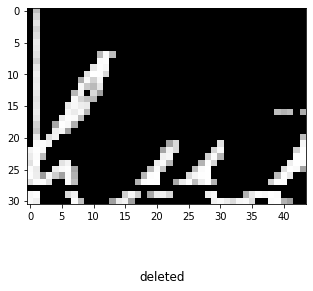

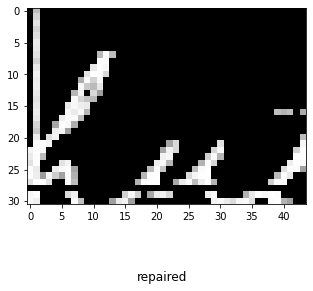

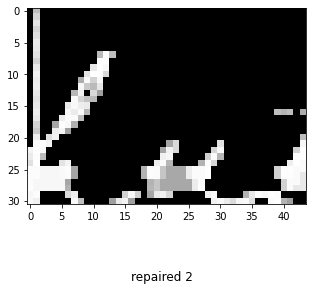

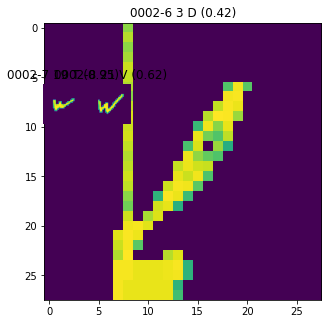

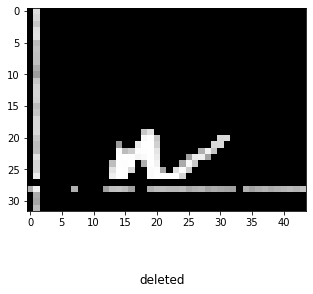

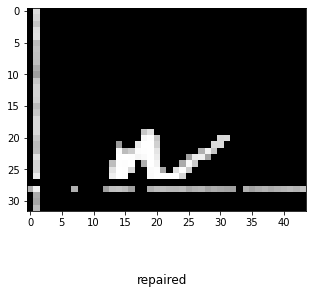

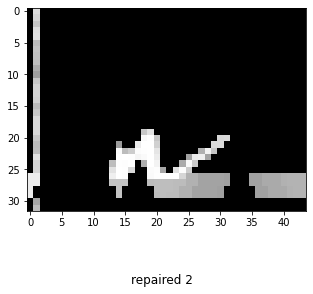

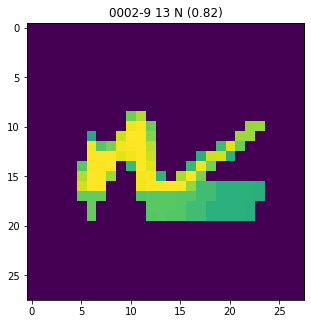

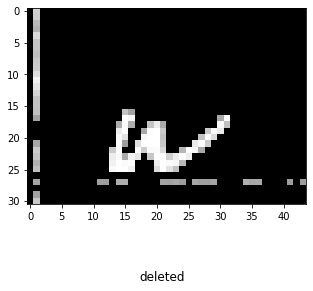

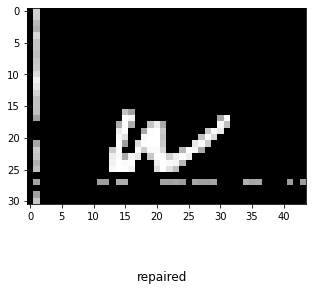

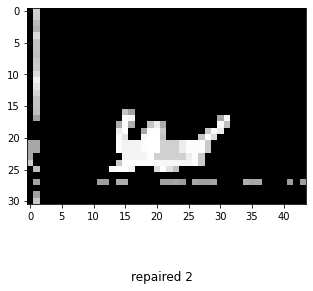

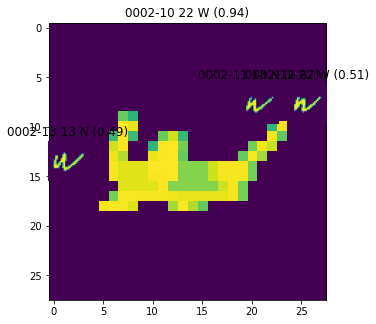

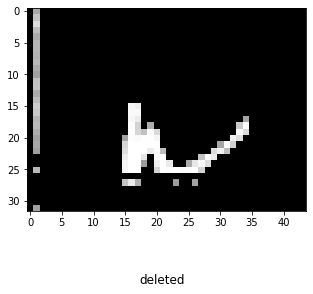

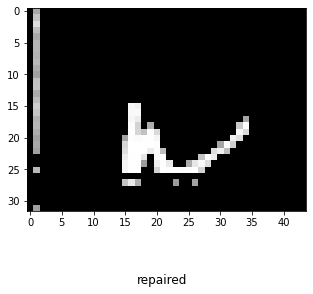

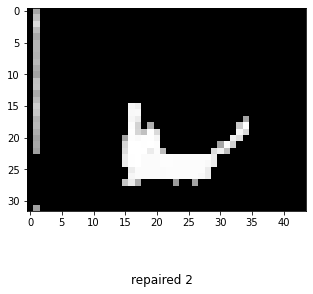

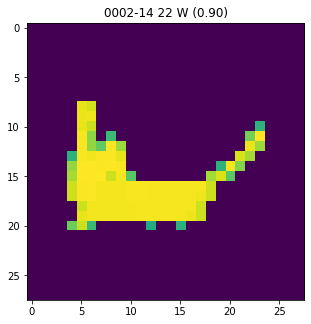

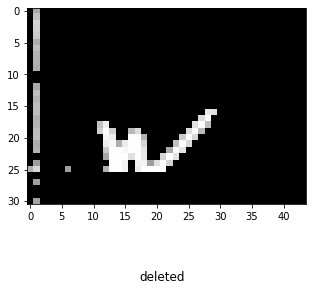

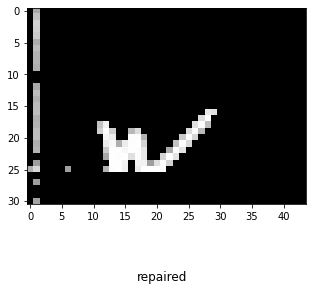

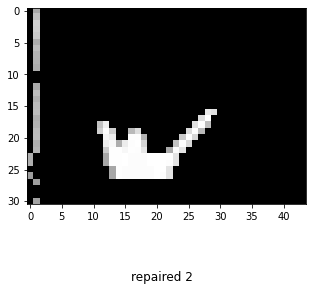

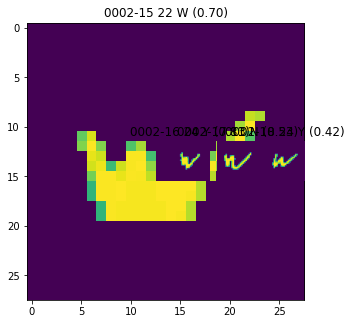

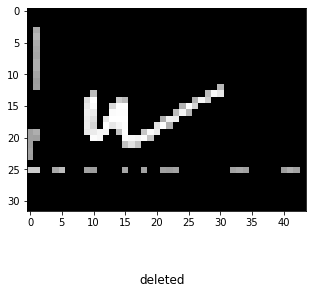

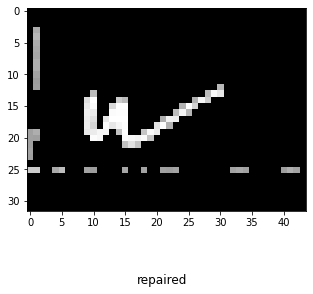

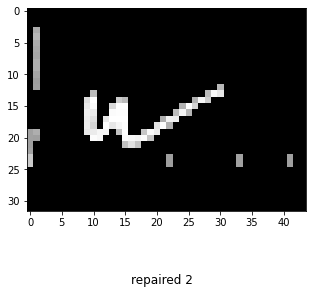

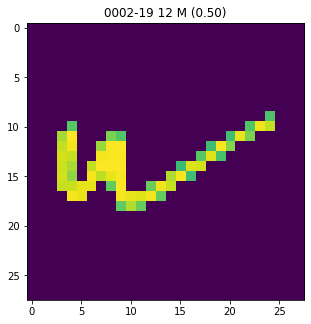

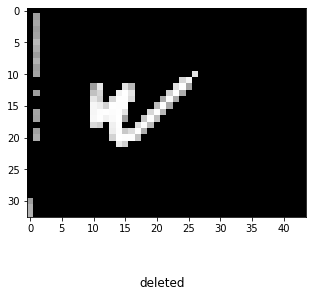

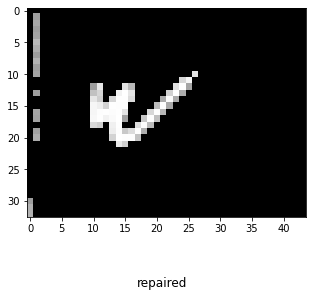

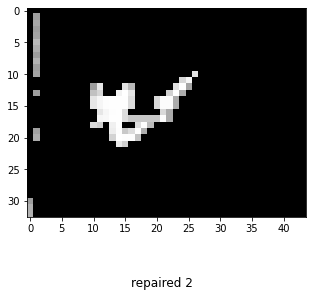

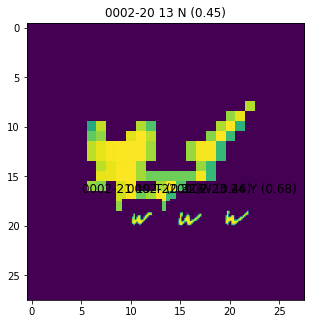

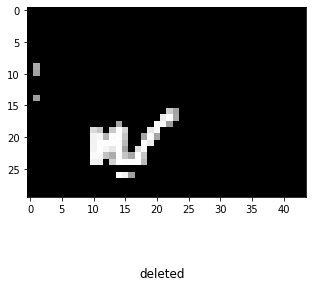

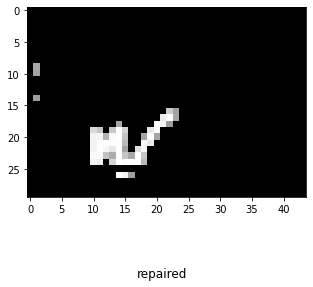

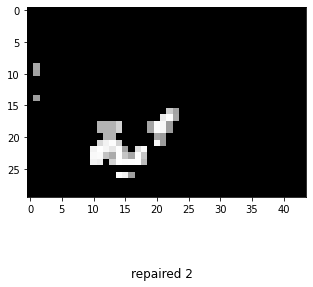

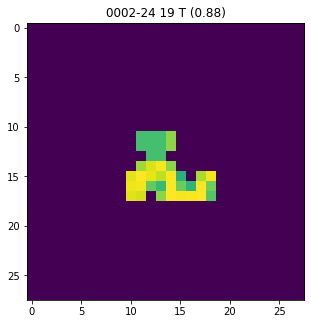

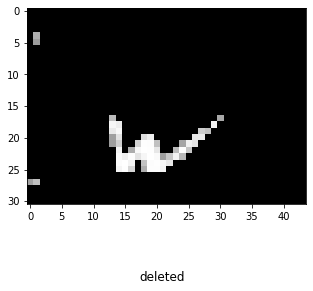

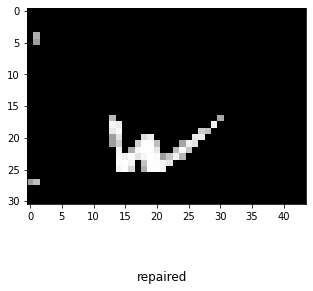

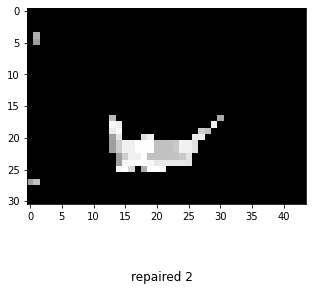

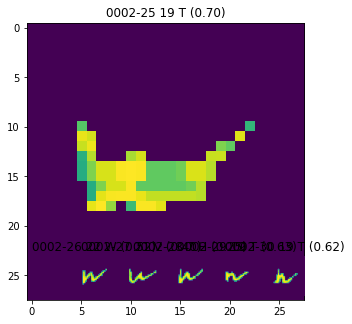

pages/43290879-California-101393-0003.jpeg


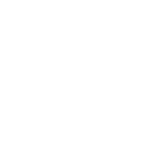

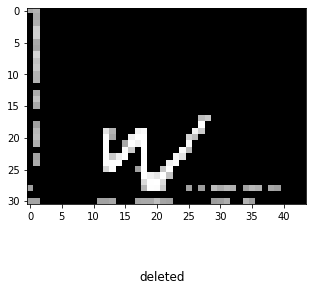

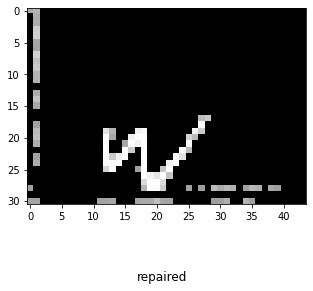

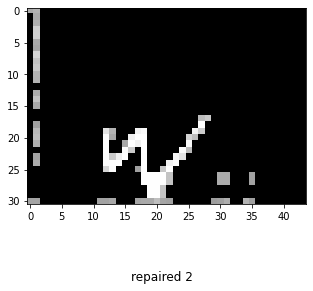

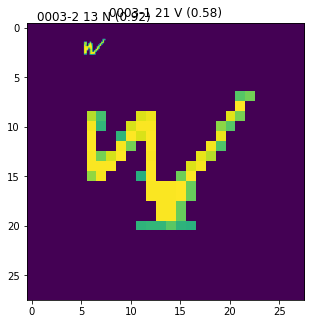

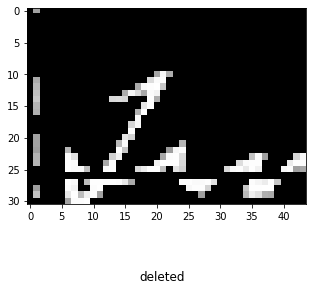

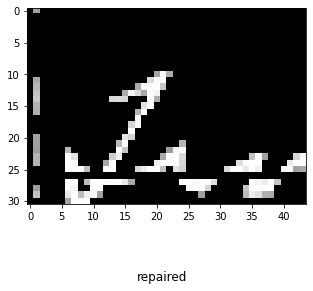

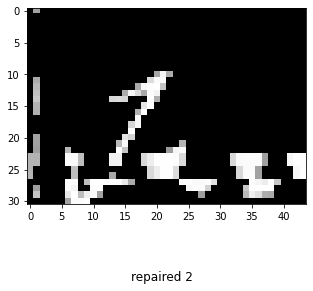

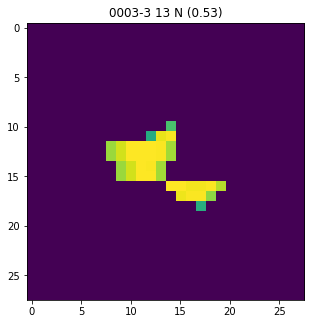

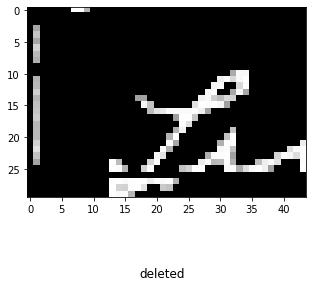

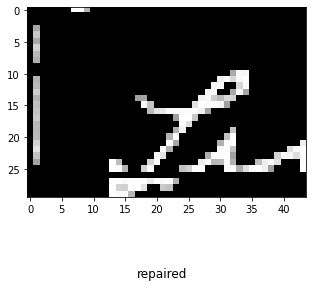

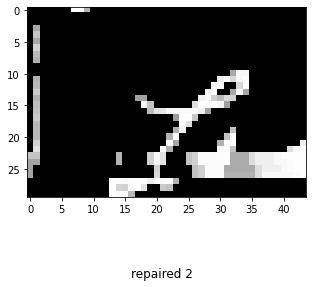

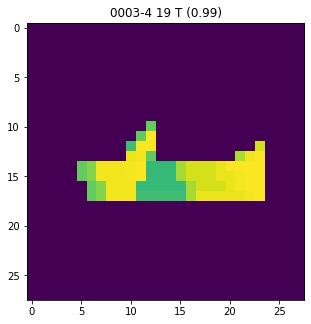

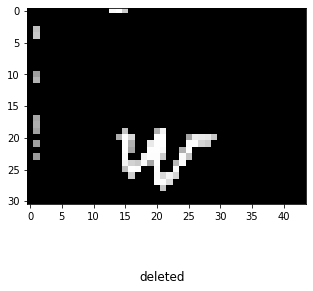

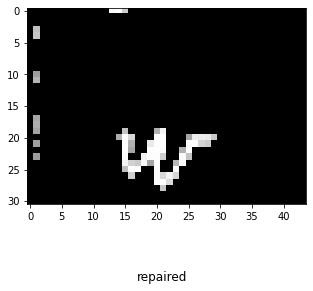

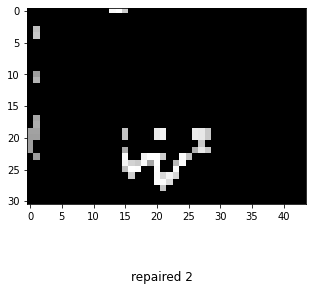

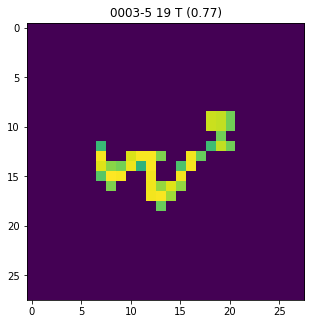

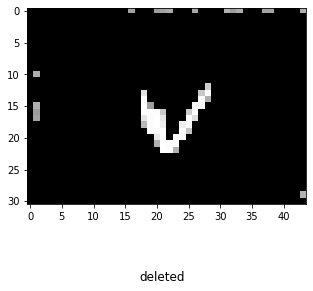

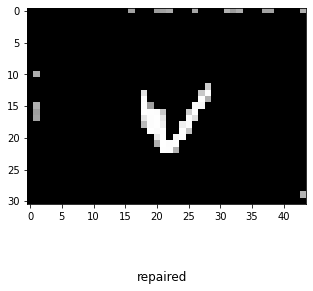

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/morph.dispatch.cpp:1022: error: (-215:Assertion failed) !src.empty() in function 'dilate'


In [9]:
import glob
import re
import cv2

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())
not_Ws = {
    2: [6],
    3: [3, 4, 11, 12, 28],
    4: [],
    5: [],
    6: [3,4],
    7: []
}

Ws = 30*5-8

def run(path, page_range=(2, 16), model=None, debug=False):
    cnt_detected = 0
    cnt_true_positive = 0
    cnt_false_positive = 0
    cnt_true_negative = 0
    cnt_false_negative = 0
    
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        plt.figure(figsize=(16, 16))
        print(f)
        image = cv2.imread(f)
        (adjusted_img, v_lines, h_lines) = extract(image, f, debug=debug)
        grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
        grayimage = 255 - grayimage
        demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
        demo_width = v_lines[12] - demo_h_offset  # width calculation
        # Open CV rectangles calculation for each demographic cell
        demographic_cells = \
          [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
        for i in range(3, len(h_lines)-1):
            num = i-2
            ax = plt.subplot(5, 6, i - 2)
            plt.axis('off')
            cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
            prepared_cell_image = crop_cell(cell_img)
            tensor, noop = normalize_img(prepared_cell_image, 0)
            result = model.predict(np.expand_dims(tensor, 0), verbose=0)
            classes_x=np.argmax(result,axis=1)
            if classes_x[0] == 22:
                cnt_detected += 1
                if num in not_Ws[int(pagestr)]:
                    cnt_false_positive += 1
                else:
                    cnt_true_positive += 1
            else:
                if num in not_Ws[int(pagestr)]:
                    cnt_true_negative += 1
                else:
                    cnt_false_negative += 1
            plt.imshow(prepared_cell_image)
            plt.title(f'{pagestr}-{num} {classes_x[0]-1} {lookup[int(classes_x[0])-1]} ({result[0][int(classes_x[0])]:.2f})')
        plt.show()
    print(f'precision {cnt_true_positive/cnt_detected} recall {cnt_true_positive/Ws}')

run('pages', page_range=(2,8), model=model)

### Results

Looking at the results we see that precision is perfect, but recall is quite poor, at less than ten percent of Ws being detected. We definitely want to detect more Ws than this if we want to save researchers time.

## Using a Convolutional Neural Network (CNN)

A convolutional neural network is inspired by the topology of the optic nerve in animals, which includes layers of locally interconnected neurons that recognize minor features in parts of an image. A CNN defines kernels of locally connected neurons of a certain size. These "context windows" are 3x3 pixels in our model, which includes two such convolved layers.

In [10]:
conv_model = tf.keras.models.Sequential(
  [
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(27, activation="softmax"),
  ] 
)

conv_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

conv_model.summary()

conv_model.fit(
    ds_train_final,
    epochs=15,
    validation_data=ds_test_final,
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 27)                │     43,227 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 62,043 (242.36 KB)

 Trainable params: 62,043 (242.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.3901 - sparse_categorical_accuracy: 0.5895 - val_loss: 0.4764 - val_sparse_categorical_accuracy: 0.8498
Epoch 2/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.3770 - val_sparse_categorical_accuracy: 0.8797
Epoch 3/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.3338 - val_sparse_categorical_accuracy: 0.8953
Epoch 4/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3583 - sparse_categorical_accuracy: 0.8853 - val_loss: 0.3145 - val_sparse_categorical_accuracy: 0.9000
Epoch 5/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3285 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2912 - val_sparse_categorical_accuracy: 0.9070
Epoch 6/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3080 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.2831 - val_sparse_categorical_accuracy: 0.9103
Epoc

pages/43290879-California-101393-0002.jpeg


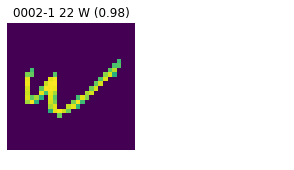

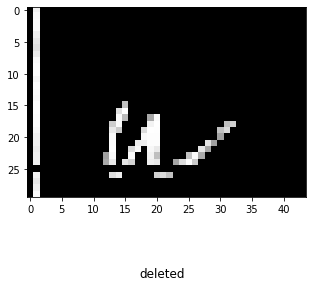

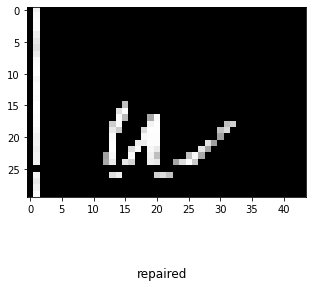

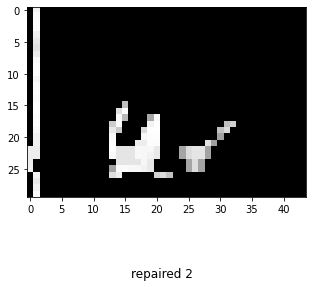

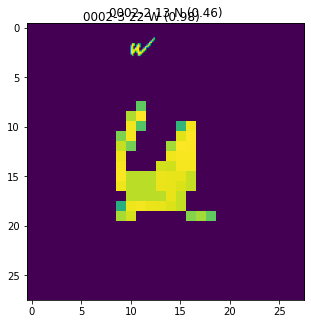

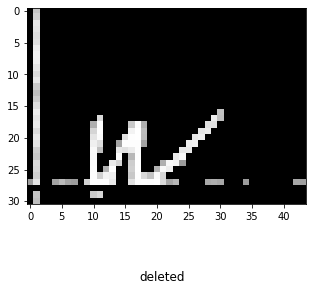

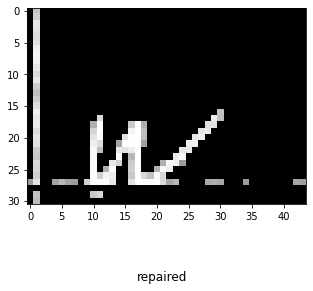

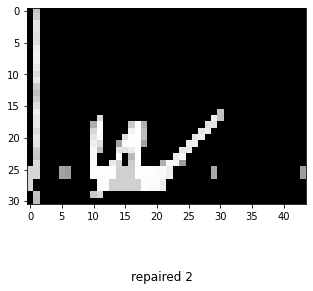

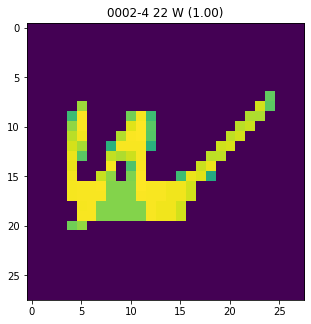

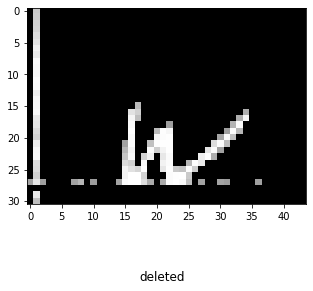

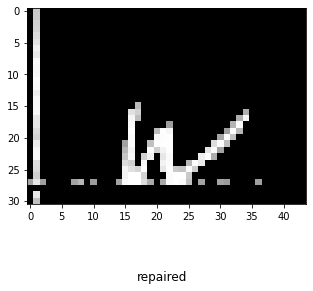

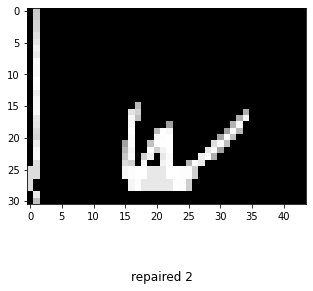

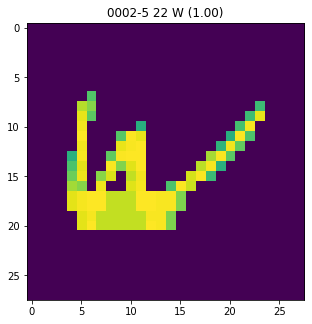

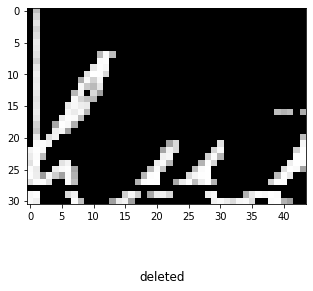

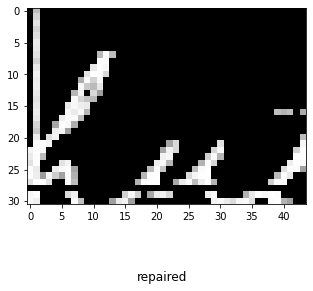

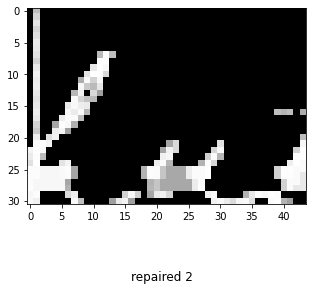

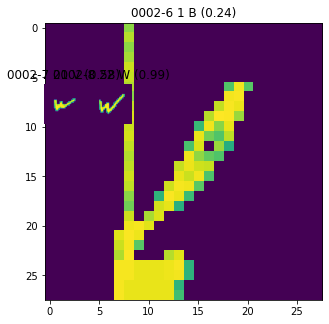

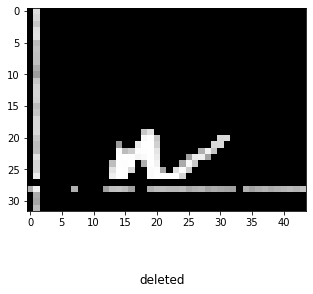

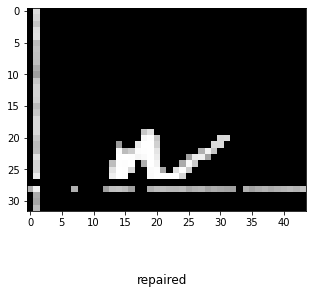

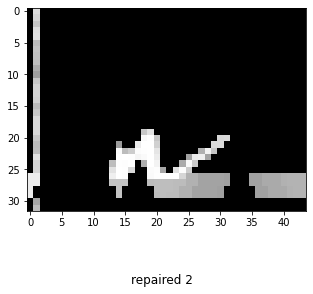

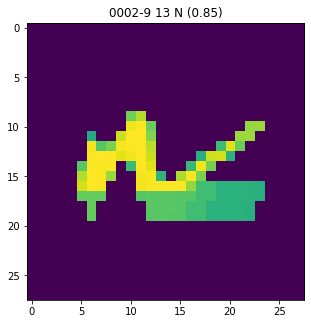

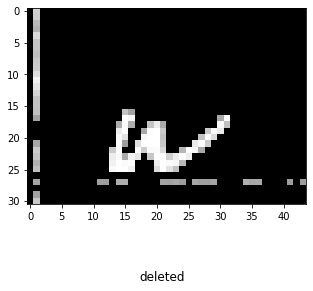

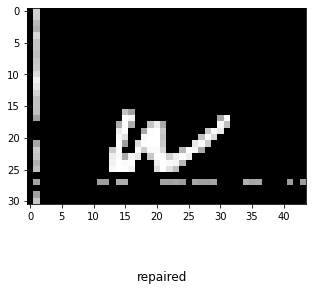

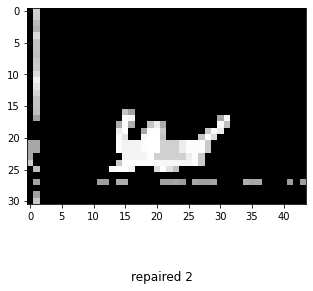

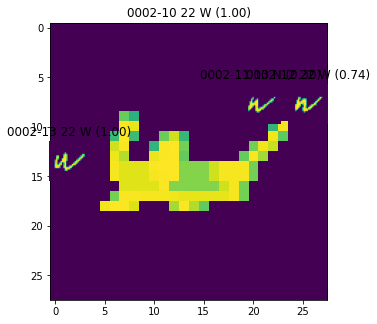

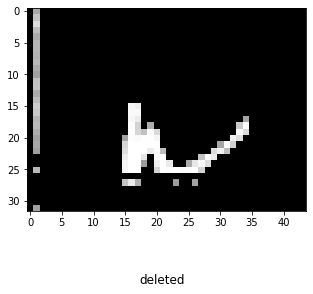

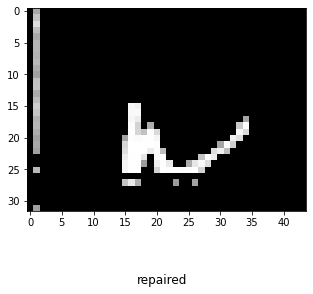

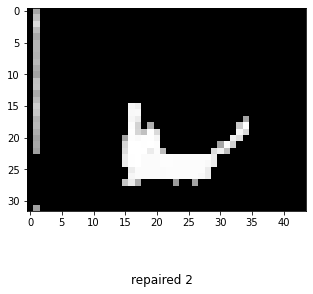

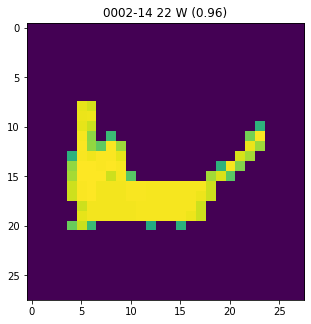

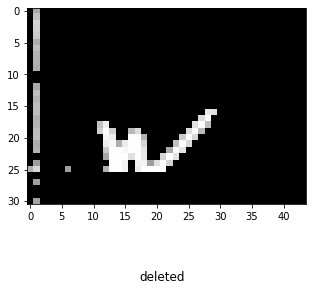

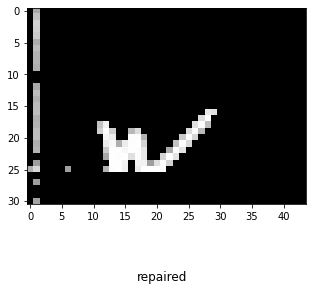

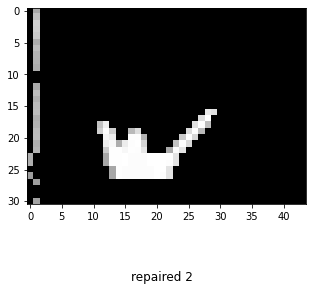

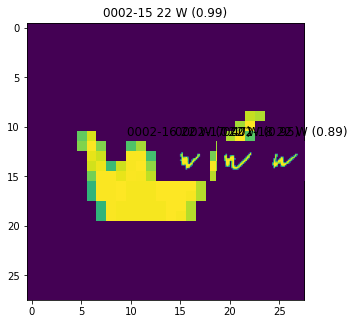

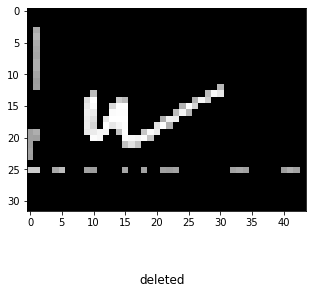

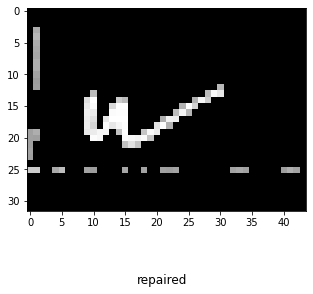

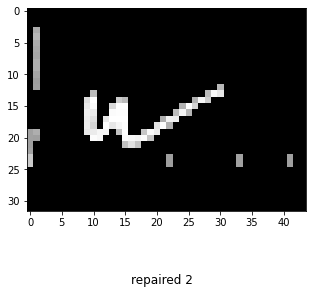

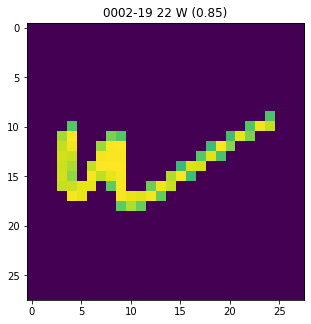

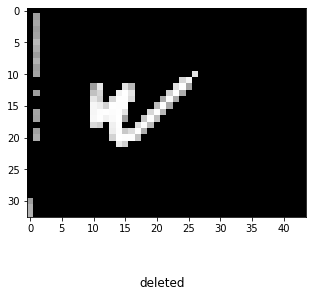

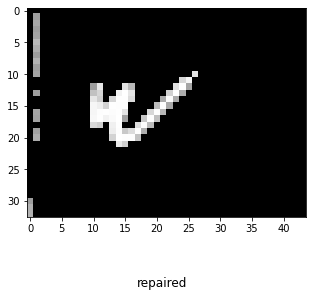

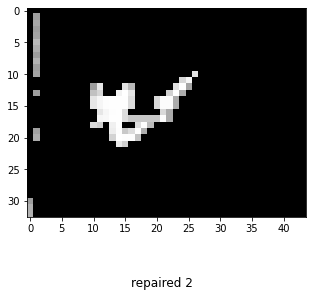

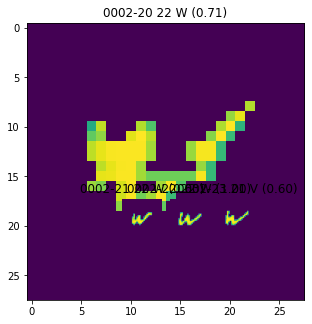

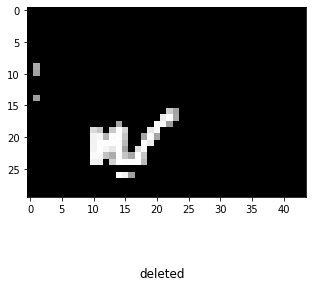

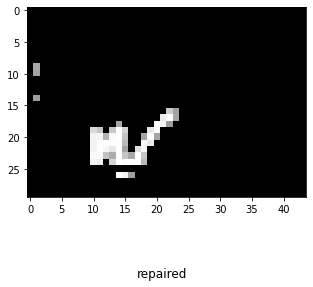

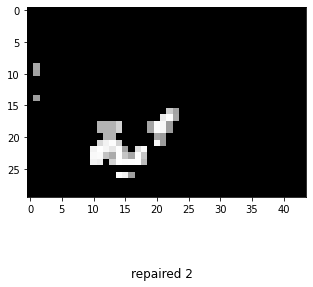

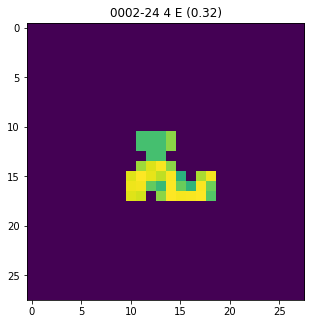

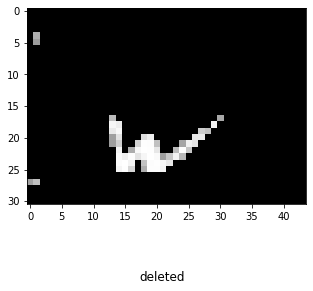

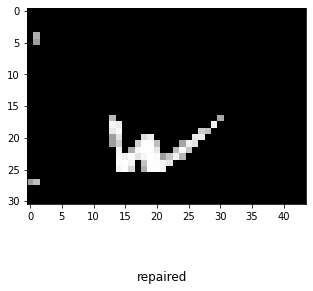

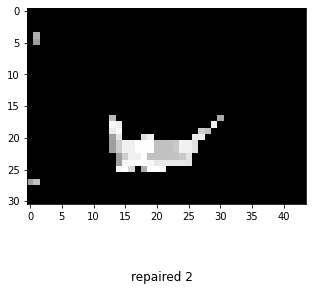

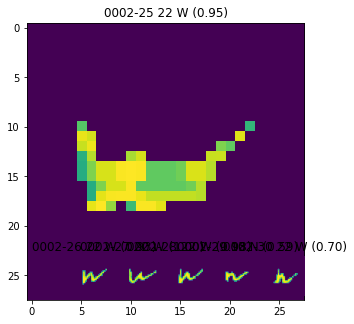

pages/43290879-California-101393-0003.jpeg


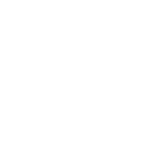

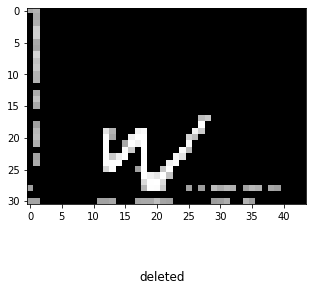

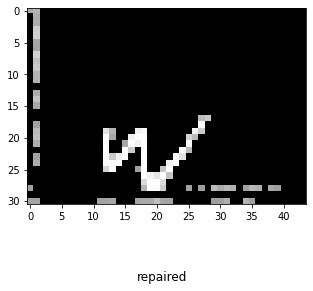

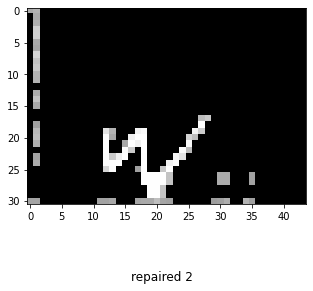

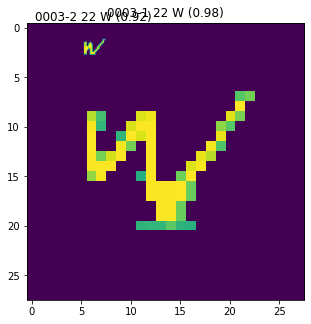

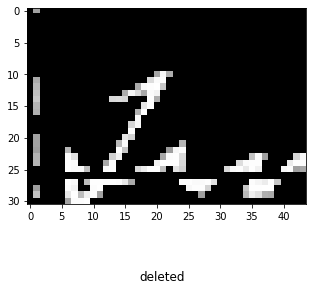

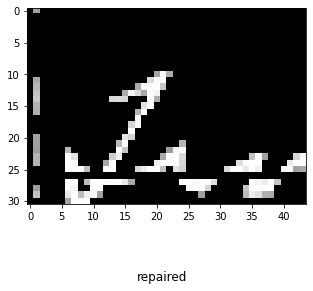

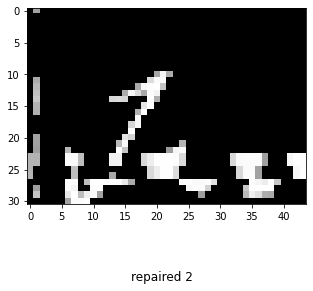

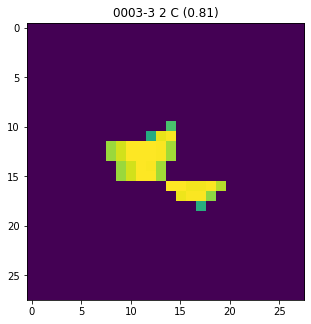

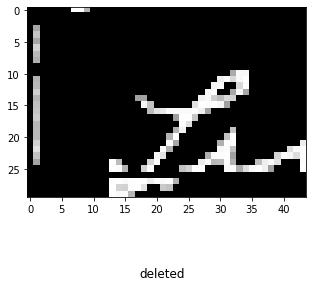

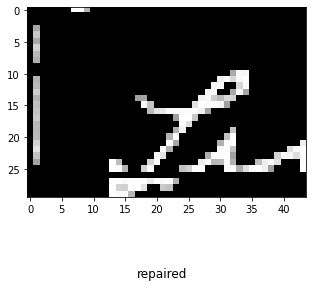

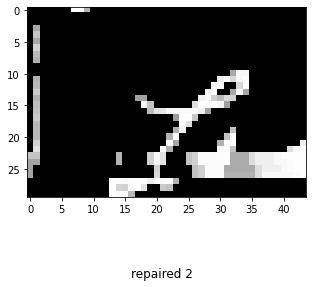

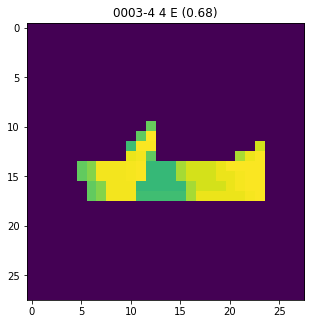

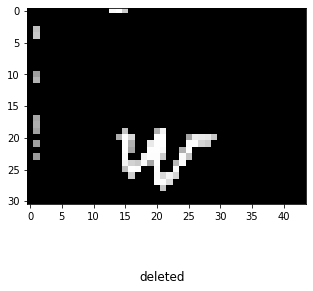

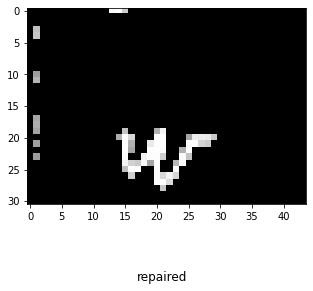

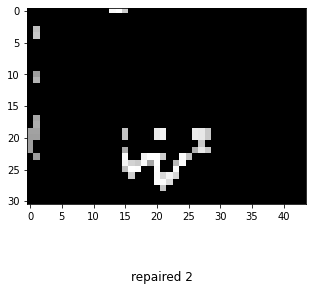

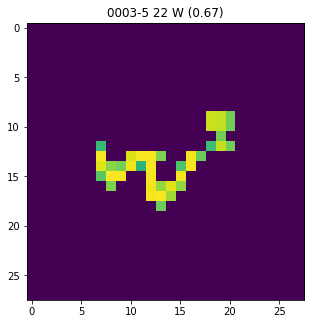

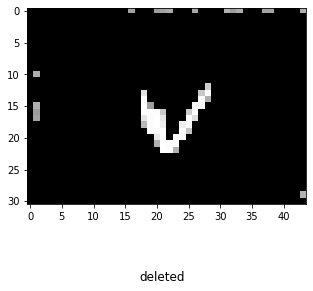

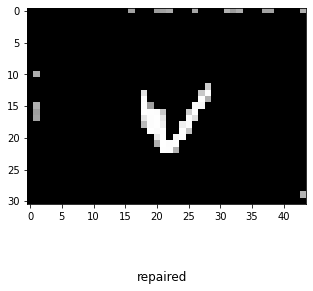

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/morph.dispatch.cpp:1022: error: (-215:Assertion failed) !src.empty() in function 'dilate'


In [11]:
run('pages', page_range=(2,8), model=conv_model)

### Results

This time we see an improvement in recall. The model is seeing more Ws and this is having no impact on its precision, which remains at 1.
To take things further we will have to look into other ways in which our training data does not match our target data. For more on this, please see [Notebook 4: Imbalanced Data](4_Imbalanced_Data.ipynb).

In [1]:
run('pages', page_range=(2,8), model=conv_model, threshold=0.04)

Exception: File `'(pages,'` not found.

In [ ]:
model.save("dense_model.keras", overwrite=True)
conv_model.save("conv_model.keras", overwrite=True)